In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob

In [2]:
path = "/mnt/disks/sdc/BQ/"

In [3]:
colors = [np.array([225,85,25]),
         np.array([45,121,198]),
         np.array([134,185,58])]
colors = [x/255 for x in colors]
#colors_out = [x/255 for x in colors]

#### Auther level sim

In [4]:
all_files = glob.glob(path + "/avg_author_sim_prop*.csv")

In [7]:
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

In [8]:
groups = pd.unique(data['group_aut'])[:-1]

In [9]:
nb_groups = len(groups)

In [10]:
groups

array(['Health Sciences', 'Social Sciences',
       'Natural Sciences and Engineering', 'Arts and Humanities'], dtype=object)

In [25]:
plt.close()

In [11]:
plt.figure(figsize=(15,15))

for i in range(nb_groups):
    group = groups[i]
    x1 = data.loc[(data['group_aut']==group) & (data['Type_Cit']==0),'sim']
    x2 = data.loc[(data['group_aut']==group) & (data['Type_Cit']==1),'sim']
    x3 = data.loc[(data['group_aut']==group) & (data['Type_Cit']==2),'sim']
    
    n_bins = 125
    kwargs = dict(histtype='step', alpha=1, bins=n_bins,linewidth=3)
    ax = plt.subplot(2,2,i+1)
    
    plt.hist(x3, **kwargs, color=colors[0], label='Others')
    plt.hist(x2, **kwargs, color=colors[1], label='Network')
    plt.hist(x1, **kwargs, color=colors[2], label='Self')
    plt.xlabel('Similarity')

    kwargs = dict(alpha=0.2, bins=n_bins,linewidth=3)
    plt.hist(x3, **kwargs, color=colors[0], label='Others')
    plt.hist(x2, **kwargs, color=colors[1], label='Network')
    plt.hist(x1, **kwargs, color=colors[2], label='Self')
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

    scale_y = 1e3
    y_vals = ax.get_yticks()
    if group == 'Arts and Humanities':
        ax.set_yticklabels(['{:.1f}'.format(x /scale_y) for x in y_vals])
    else:
        ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=18)
    plt.title(group,size=25)
    plt.ylabel('Frequency [k]')
    #plt.gca().set(title=disc, ylabel='Frequency')
    plt.legend()
out_path = path+'results_sim_bq/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path+'hist_avg_per_authors.png')
plt.savefig(out_path+'hist_avg_per_authors.svg')
plt.close()

#### Sim by prop sim x (inverted)

In [33]:
df_prop = data.copy()
df_prop = df_prop.loc[df_prop['Count_Cluster']>=20]

In [34]:
bins = np.linspace(0,1,21)
df_hist = df_prop.copy()
df_hist['binned'] = pd.cut(df_hist['sim'],bins)
df_hist = df_hist.groupby(['binned','Type_Cit','group_aut']).agg({'prop_cit':'count'}).reset_index()
df_hist.columns = ["".join(x) for x in df_hist.columns.ravel()]
df_hist['bin_x'] = df_hist.apply(lambda x: x['binned'].mid,axis=1)

In [35]:
for group in groups:
    for type_cit in range(3):
        df_prop.loc[(df_prop['group_aut'] == group) & (df_prop['Type_Cit'] == type_cit),'qbinned'] = pd.qcut(df_prop.loc[(df_prop['group_aut'] == group) & 
                                                                                                                     (df_prop['Type_Cit'] == type_cit),'sim'],15)

In [36]:
df_prop = df_prop.groupby(['qbinned','Type_Cit','group_aut']).agg({'prop_cit':['mean','count']}).reset_index()

In [37]:
df_prop.columns = ["".join(x) for x in df_prop.columns.ravel()]

In [38]:
df_prop['bin_x'] = df_prop.apply(lambda x: x['qbinned'].mid,axis=1)

In [39]:
plt.figure(figsize=(15,15))

for i in range(nb_groups):
    group = groups[i]
    x1 = df_prop.loc[(df_prop['group_aut']==group) & (df_prop['Type_Cit']==0),
                          ['bin_x','prop_citmean']]
    x2 = df_prop.loc[(df_prop['group_aut']==group) & (df_prop['Type_Cit']==1),
                          ['bin_x','prop_citmean']]
    x3 = df_prop.loc[(df_prop['group_aut']==group) & (df_prop['Type_Cit']==2),
                          ['bin_x','prop_citmean']]
    
    
    kwargs = dict(alpha=1,linewidth=2,marker=".",markersize=10)
    ax = plt.subplot(2,2,i+1)
    
    plt.plot(x3['bin_x'],x3['prop_citmean'], **kwargs, color=colors[0], label='Others')
    plt.plot(x2['bin_x'],x2['prop_citmean'],**kwargs, color=colors[1], label='Network')
    plt.plot(x1['bin_x'],x1['prop_citmean'], **kwargs, color=colors[2], label='Self')
    
    
   
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

    plt.title(group,size=25)
    plt.ylabel('Proportion citation type')
    #plt.gca().set(title=disc, ylabel='Frequency')
    plt.legend()
    plt.tick_params(labelsize=20)
    plt.rcParams.update({'font.size': 22})
    plt.xlabel('Average similarity')
    ax2 = ax.twinx()
    x1 = df_hist.loc[(df_hist['group_aut']==group) & (df_hist['Type_Cit']==0),
                          ['bin_x','prop_cit']]
    x2 = df_hist.loc[(df_hist['group_aut']==group) & (df_hist['Type_Cit']==1),
                          ['bin_x','prop_cit']]
    x3 = df_hist.loc[(df_hist['group_aut']==group) & (df_hist['Type_Cit']==2),
                          ['bin_x','prop_cit']]
    
    
    kwargs = dict(alpha=0.5,linewidth=3,linestyle='--')
    
    plt.plot(x3['bin_x'],x3['prop_cit'], **kwargs, color=colors[0], label='Others')
    plt.plot(x2['bin_x'],x2['prop_cit'],**kwargs, color=colors[1], label='Network')
    plt.plot(x1['bin_x'],x1['prop_cit'], **kwargs, color=colors[2], label='Self')
    plt.ylabel('# Authors (k)')
    scale_y = 1e3
    y_vals = ax2.get_yticks()
    if group == 'Arts and Humanities':
        ax2.set_yticklabels(['{:.1f}'.format(x /scale_y) for x in y_vals])
    else:
        ax2.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
    plt.tick_params(labelsize=20)
    plt.rcParams.update({'font.size': 22})
out_path = path+'results_sim_bq/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path+'sim_per_prop_cit_inverted.png')
plt.savefig(out_path+'sim_per_prop_cit_inverted.svg')
plt.close()

#### Sim by prop pro x

In [44]:
df_prop = data.copy()
df_prop = df_prop.loc[df_prop['Count_Cluster']>=20]

In [45]:
bins = np.linspace(0,1,21)
df_hist = df_prop.copy()
df_hist['binned'] = pd.cut(df_hist['sim'],bins)
df_hist = df_hist.groupby(['binned','Type_Cit','group_aut']).agg({'sim':'count'}).reset_index()
df_hist.columns = ["".join(x) for x in df_hist.columns.ravel()]
df_hist['bin_x'] = df_hist.apply(lambda x: x['binned'].mid,axis=1)

In [48]:
df_prop.head()

,Aut_citant,Type_Cit,type_count,group_aut,sim,Count_Cluster,prop_cit,qbinned
1,48486112,2,32,Health Sciences,0.125057,33,0.969697,NaN
5,10572023,1,5,Natural Sciences and Engineering,0.285498,32,0.156250,NaN
7,23555270,0,1312,Social Sciences,0.250287,8101,0.161955,NaN
8,37790961,2,26,Natural Sciences and Engineering,0.119449,26,1.000000,NaN
9,24360679,2,32,Natural Sciences and Engineering,0.204781,33,0.969697,NaN


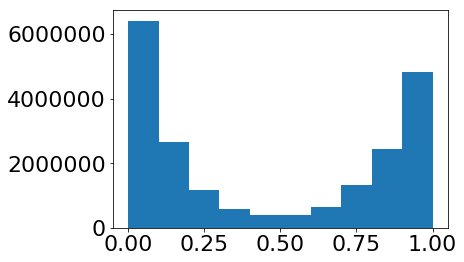

In [49]:
plt.hist(df_prop['prop_cit'])
plt.show()

In [52]:
for group in groups:
    for type_cit in range(3):
        df_prop.loc[(df_prop['group_aut'] == group) & (df_prop['Type_Cit'] == type_cit),'qbinned'] = pd.qcut(df_prop.loc[(df_prop['group_aut'] == group) & 
                                                                                                                     (df_prop['Type_Cit'] == type_cit),'prop_cit'],15,duplicates='drop')

In [53]:
df_prop = df_prop.groupby(['qbinned','Type_Cit','group_aut']).agg({'sim':['mean','count']}).reset_index()
df_prop.columns = ["".join(x) for x in df_prop.columns.ravel()]
df_prop['bin_x'] = df_prop.apply(lambda x: x['qbinned'].mid,axis=1)

In [56]:
plt.figure(figsize=(15,15))

for i in range(nb_groups):
    group = groups[i]
    x1 = df_prop.loc[(df_prop['group_aut']==group) & (df_prop['Type_Cit']==0),
                          ['bin_x','simmean']]
    x2 = df_prop.loc[(df_prop['group_aut']==group) & (df_prop['Type_Cit']==1),
                          ['bin_x','simmean']]
    x3 = df_prop.loc[(df_prop['group_aut']==group) & (df_prop['Type_Cit']==2),
                          ['bin_x','simmean']]
    
    
    kwargs = dict(alpha=1,linewidth=2,marker=".",markersize=10)
    ax = plt.subplot(2,2,i+1)
    
    plt.plot(x3['bin_x'],x3['simmean'], **kwargs, color=colors[0], label='Others')
    plt.plot(x2['bin_x'],x2['simmean'],**kwargs, color=colors[1], label='Network')
    plt.plot(x1['bin_x'],x1['simmean'], **kwargs, color=colors[2], label='Self')
    
    
   
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

#     scale_y = 1e3
#     y_vals = ax.get_yticks()
#     if i == 0:
#         ax.set_yticklabels(['{:.1f}'.format(x /scale_y) for x in y_vals])
#     else:
#         ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
    #plt.xlim([1980,2019])
    #plt.ylim([0.1,0.5])

    plt.title(group,size=25)
    plt.ylabel('Average similarity')
    #plt.gca().set(title=disc, ylabel='Frequency')
    plt.legend()
    plt.tick_params(labelsize=20)
    plt.rcParams.update({'font.size': 22})
    plt.xlabel('Proportion citation type')
    ax2 = ax.twinx()
    x1 = df_hist.loc[(df_hist['group_aut']==group) & (df_hist['Type_Cit']==0),
                          ['bin_x','sim']]
    x2 = df_hist.loc[(df_hist['group_aut']==group) & (df_hist['Type_Cit']==1),
                          ['bin_x','sim']]
    x3 = df_hist.loc[(df_hist['group_aut']==group) & (df_hist['Type_Cit']==2),
                          ['bin_x','sim']]
    
    
    kwargs = dict(alpha=0.5,linewidth=3,linestyle='--')
    
    plt.plot(x3['bin_x'],x3['sim'], **kwargs, color=colors[0], label='Others')
    plt.plot(x2['bin_x'],x2['sim'],**kwargs, color=colors[1], label='Network')
    plt.plot(x1['bin_x'],x1['sim'], **kwargs, color=colors[2], label='Self')
    plt.ylabel('# Authors (k)')
    scale_y = 1e3
    y_vals = ax2.get_yticks()
    if group == 'Arts and Humanities':
        ax2.set_yticklabels(['{:.2f}'.format(x /scale_y) for x in y_vals])
    else:
        ax2.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
    plt.tick_params(labelsize=20)
    plt.rcParams.update({'font.size': 22})
out_path = path+'results_sim_bq/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path+'sim_per_prop_cit.png')
plt.savefig(out_path+'sim_per_prop_cit.svg')
plt.close()


## Year level sim

### year citing

In [57]:
avg_sim_year = pd.read_csv(path+'avg_year_citant_sim.csv')

In [58]:
avg_sim_year.head()

,Annee_Citant,Type_Cit,group,sim,count
0,1934,0,Natural Sciences and Engineering,0.557007,3
1,1950,0,Natural Sciences and Engineering,0.253662,2
2,1955,0,Natural Sciences and Engineering,0.451904,2
3,1956,0,Natural Sciences and Engineering,0.432427,9
4,1957,0,Health Sciences,0.637695,1


In [60]:
plt.figure(figsize=(15,15))

for i in range(nb_groups):
    group = groups[i]
    x1 = avg_sim_year.loc[(avg_sim_year['group']==group) & (avg_sim_year['Type_Cit']==0),
                          ['sim','Annee_Citant']]
    x2 = avg_sim_year.loc[(avg_sim_year['group']==group) & (avg_sim_year['Type_Cit']==1),
                          ['sim','Annee_Citant']]
    x3 = avg_sim_year.loc[(avg_sim_year['group']==group) & (avg_sim_year['Type_Cit']==2),
                          ['sim','Annee_Citant']]
    
    
    
    kwargs = dict(alpha=1,linewidth=3)
    ax = plt.subplot(2,2,i+1)
    
    plt.plot(x3['Annee_Citant'],x3['sim'], **kwargs, color=colors[0], label='Others')
    plt.plot(x2['Annee_Citant'],x2['sim'], **kwargs, color=colors[1], label='Network')
    plt.plot(x1['Annee_Citant'],x1['sim'], **kwargs, color=colors[2], label='Self')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

#     scale_y = 1e3
#     y_vals = ax.get_yticks()
#     if i == 0:
#         ax.set_yticklabels(['{:.1f}'.format(x /scale_y) for x in y_vals])
#     else:
#         ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
    plt.xlim([1995,2019])
    plt.ylim([0.1,0.5])
    plt.title(group,size=25)
    plt.ylabel('Average similarity')
    plt.tick_params(labelsize=20)
    plt.rcParams.update({'font.size': 22})
    plt.xlabel('Year citing')
    #plt.gca().set(title=disc, ylabel='Frequency')
    plt.legend()
out_path = path+'results_sim_bq/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path+'avg_year_citing.png')
plt.savefig(out_path+'avg_year_citing.svg')
plt.close()

### year cited

In [62]:
avg_sim_year = pd.read_csv(path+'avg_year_cite_sim.csv')

In [64]:
plt.figure(figsize=(15,15))

for i in range(nb_groups):
    group = groups[i]
    x1 = avg_sim_year.loc[(avg_sim_year['group']==group) & (avg_sim_year['Type_Cit']==0),
                          ['sim','Annee_Cite']]
    x2 = avg_sim_year.loc[(avg_sim_year['group']==group) & (avg_sim_year['Type_Cit']==1),
                          ['sim','Annee_Cite']]
    x3 = avg_sim_year.loc[(avg_sim_year['group']==group) & (avg_sim_year['Type_Cit']==2),
                          ['sim','Annee_Cite']]
    
    
    
    kwargs = dict(alpha=1,linewidth=3)
    ax = plt.subplot(2,2,i+1)
    
    plt.plot(x3['Annee_Cite'],x3['sim'], **kwargs, color=colors[0], label='Others')
    plt.plot(x2['Annee_Cite'],x2['sim'], **kwargs, color=colors[1], label='Network')
    plt.plot(x1['Annee_Cite'],x1['sim'], **kwargs, color=colors[2], label='Self')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

#     scale_y = 1e3
#     y_vals = ax.get_yticks()
#     if i == 0:
#         ax.set_yticklabels(['{:.1f}'.format(x /scale_y) for x in y_vals])
#     else:
#         ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
    plt.xlim([1995,2019])
    plt.ylim([0.1,0.5])
    plt.title(group,size=25)
    plt.ylabel('Average similarity')
    plt.tick_params(labelsize=20)
    plt.rcParams.update({'font.size': 22})
    plt.xlabel('Year cited')
    #plt.gca().set(title=disc, ylabel='Frequency')
    plt.legend()
out_path = path+'results_sim_bq/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path+'avg_year_cited.png')
plt.savefig(out_path+'avg_year_cited.svg')
plt.close()

### Age citation

In [66]:
avg_sim_age = pd.read_csv(path+'avg_age_citation_sim.csv')

In [71]:
plt.figure(figsize=(15,15))

for i in range(nb_groups):
    group = groups[i]
    x1 = avg_sim_age.loc[(avg_sim_age['group']==group) & (avg_sim_age['Type_Cit']==0),
                          ['sim','age_citation']]
    x2 = avg_sim_age.loc[(avg_sim_age['group']==group) & (avg_sim_age['Type_Cit']==1),
                          ['sim','age_citation']]
    x3 = avg_sim_age.loc[(avg_sim_age['group']==group) & (avg_sim_age['Type_Cit']==2),
                          ['sim','age_citation']]
    
    
    
    kwargs = dict(alpha=1,linewidth=3)
    ax = plt.subplot(2,2,i+1)
    
    plt.plot(x3['age_citation'],x3['sim'], **kwargs, color=colors[0], label='Others')
    plt.plot(x2['age_citation'],x2['sim'], **kwargs, color=colors[1], label='Network')
    plt.plot(x1['age_citation'],x1['sim'], **kwargs, color=colors[2], label='Self')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

#     scale_y = 1e3
#     y_vals = ax.get_yticks()
#     if i == 0:
#         ax.set_yticklabels(['{:.1f}'.format(x /scale_y) for x in y_vals])
#     else:
#         ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
    plt.xlim([0,40])
    #plt.ylim([0.1,0.5])
    plt.title(group,size=25)
    plt.ylabel('Average similarity')
    plt.tick_params(labelsize=20)
    plt.rcParams.update({'font.size': 22})
    plt.xlabel('Age cited')
    #plt.gca().set(title=disc, ylabel='Frequency')
    plt.legend()
out_path = path+'results_sim_bq/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path+'age_citation.png')
plt.savefig(out_path+'age_citation.svg')
plt.close()

### Age author

In [72]:
avg_sim_age = pd.read_csv(path+'avg_age_author_sim.csv')

In [74]:
avg_sim_age.head()

,age_author,Type_Cit,group,sim,std_sim,count
0,1,0,Social Sciences,0.380393,0.198266,38363
1,1,0,Natural Sciences and Engineering,0.370314,0.196300,272059
2,1,0,Health Sciences,0.397254,0.204309,146796
3,1,0,Arts and Humanities,0.322907,0.206989,342
4,1,0,NaN,0.308765,0.133830,5


In [76]:
plt.figure(figsize=(15,15))

for i in range(nb_groups):
    group = groups[i]
    x1 = avg_sim_age.loc[(avg_sim_age['group']==group) & (avg_sim_age['Type_Cit']==0),
                          ['sim','age_author']]
    x2 = avg_sim_age.loc[(avg_sim_age['group']==group) & (avg_sim_age['Type_Cit']==1),
                          ['sim','age_author']]
    x3 = avg_sim_age.loc[(avg_sim_age['group']==group) & (avg_sim_age['Type_Cit']==2),
                          ['sim','age_author']]
    
    
    
    kwargs = dict(alpha=1,linewidth=3)
    ax = plt.subplot(2,2,i+1)
    
    plt.plot(x3['age_author'],x3['sim'], **kwargs, color=colors[0], label='Others')
    plt.plot(x2['age_author'],x2['sim'], **kwargs, color=colors[1], label='Network')
    plt.plot(x1['age_author'],x1['sim'], **kwargs, color=colors[2], label='Self')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

#     scale_y = 1e3
#     y_vals = ax.get_yticks()
#     if i == 0:
#         ax.set_yticklabels(['{:.1f}'.format(x /scale_y) for x in y_vals])
#     else:
#         ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
    plt.xlim([0,40])
    #plt.ylim([0.1,0.5])
    plt.title(group,size=25)
    plt.ylabel('Average similarity')
    plt.tick_params(labelsize=20)
    plt.rcParams.update({'font.size': 22})
    plt.xlabel('Age author')
    #plt.gca().set(title=disc, ylabel='Frequency')
    plt.legend()
out_path = path+'results_sim_bq/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path+'age_author.png')
plt.savefig(out_path+'age_author.svg')
plt.close()

## Article sim

In [78]:
df_avg = pd.read_csv(path+'avg_sim_articles.csv')

In [80]:
df_avg.head()

,Type_Cit,group,sim,std_sim,count
0,0,Social Sciences,0.279379,0.177241,21397007
1,0,Natural Sciences and Engineering,0.273712,0.172080,55367658
2,0,NaN,0.255094,0.168474,152568
3,0,Arts and Humanities,0.268641,0.171695,63342
4,0,Health Sciences,0.297990,0.187042,22585867


In [81]:
df_avg['sem'] = np.divide(df_avg['std_sim'],np.sqrt(df_avg['count']))

In [79]:
colors_groups = [np.array([168,23,36]),
         np.array([247,42,49]),
         np.array([124,185,0]),
         np.array([155,215,23])]
colors_groups = [x/255 for x in colors_groups]

In [83]:
plt.figure(figsize=(8,8))
ax = plt.axes()

group = groups[i]
x1 = df_avg.loc[(df_avg['group']==groups[0]),['sim','sem','Type_Cit']]
x2 = df_avg.loc[(df_avg['group']==groups[1]),['sim','sem','Type_Cit']]
x3 = df_avg.loc[(df_avg['group']==groups[2]),['sim','sem','Type_Cit']]
x4 = df_avg.loc[(df_avg['group']==groups[3]),['sim','sem','Type_Cit']]




kwargs = dict(alpha=1,linewidth=3,marker='.',markersize=15)



# plt.errorbar(x1['Type_Cit'],x1['Simmean'], yerr= x1['Simsem'], **kwargs, color=colors_groups[0], label=groups[0])
# plt.errorbar(x2['Type_Cit'],x2['Simmean'], yerr= x2['Simsem'],**kwargs, color=colors_groups[1], label=groups[1])
# plt.errorbar(x3['Type_Cit'],x3['Simmean'], yerr= x3['Simsem'], **kwargs, color=colors_groups[2], label=groups[2])
# plt.errorbar(x4['Type_Cit'],x4['Simmean'], yerr= x4['Simsem'], **kwargs, color=colors_groups[3], label=groups[3])

plt.plot(x1['Type_Cit'],x1['sim'],  **kwargs, color=colors_groups[0], label=groups[0])
plt.plot(x2['Type_Cit'],x2['sim'], **kwargs, color=colors_groups[1], label=groups[1])
plt.plot(x3['Type_Cit'],x3['sim'],  **kwargs, color=colors_groups[2], label=groups[2])
plt.plot(x4['Type_Cit'],x4['sim'],  **kwargs, color=colors_groups[3], label=groups[3])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


#     scale_y = 1e3
#     y_vals = ax.get_yticks()
#     if i == 0:
#         ax.set_yticklabels(['{:.1f}'.format(x /scale_y) for x in y_vals])
#     else:
#         ax.set_yticklabels(['{:d}'.format(int(x /scale_y)) for x in y_vals])
#plt.xlim([1980,2019])
#plt.ylim([0.1,0.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Self','Network','Others'])
plt.tick_params(labelsize=20)
#plt.title(group,size=25)
plt.ylabel('Average similarity')
#plt.gca().set(title=disc, ylabel='Frequency')
plt.legend()
out_path = path+'results_sim_bq/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path+'sim_avg_per_cit_type.png')
plt.savefig(out_path+'sim_avg_per_cit_type.svg')
plt.close()